In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import tensorflow as tf

In [215]:
# Load the data
data = pd.read_excel('Kickstarter.xlsx')

# Remove the rows that are not of interest
data = data[data['state'] != 'live']
data = data[data['state'] != 'canceled']

# Create the new features
data['goal_usd'] = data['goal'] * data['static_usd_rate']
data['pledge_period'] = (data['deadline'] - data['launched_at']).dt.days
data['avg_pledge_daily'] = data['goal_usd'] / data['pledge_period']
countries = data['country'].value_counts()
countries = countries[countries > 100].index
data['other_country'] = np.where(data['country'].isin(countries), data['country'], 'Other')


# Log transform the goal_usd and avg_pledge_daily variables
data['goal_usd_log'] = np.log(data['goal_usd'])
data['avg_pledge_daily_log'] = np.log(data['avg_pledge_daily'])

# Treat the deadline month and launched_at month as categorical variables
data['deadline_month'] = data['deadline'].dt.month

# Treat the deadline year as a categorical variable
data['deadline_year'] = data['deadline'].dt.year

#Create dummies for the categorical variables
data = pd.get_dummies(data, columns = ['state', 'category', 'other_country', 'show_feature_image', 'video','deadline_weekday', 'launched_at_weekday', 'deadline_month', 'launched_at_month', 'deadline_year'], drop_first = False)


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_27348\3967629732.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['main_category'].fillna(data['category'], inplace = True)


In [195]:
data.columns

Index(['id', 'name', 'goal', 'pledged', 'country', 'currency', 'deadline',
       'state_changed_at', 'created_at', 'launched_at',
       ...
       'launched_at_month_10', 'launched_at_month_11', 'launched_at_month_12',
       'deadline_year_2018', 'deadline_year_2019', 'deadline_year_2020',
       'deadline_year_2021', 'deadline_year_2022', 'deadline_year_2023',
       'deadline_year_2024'],
      dtype='object', length=243)

In [292]:
#Select the predictors and the target variable
numerical_predictors = ['goal_usd_log', 'avg_pledge_daily_log','pledge_period', 'static_usd_rate',  'name_len_clean', 'blurb_len_clean',]
categorical_predictors = [col for col in data.columns if 'category_' in col or 'other_country_' in col or 'show_feature_image_True' in col or 'video_True' in col or 'deadline_weekday_Thursday' in col or 'launched_at_weekday_Tuesday' in col or 'deadline_month_' in col or 'deadline_year_' in col ]  
predictors = numerical_predictors + categorical_predictors
x = data[predictors]
y = data['state_successful']

#see how many columns we have
print(len(x.columns))
x.columns

189


Index(['goal_usd_log', 'avg_pledge_daily_log', 'pledge_period',
       'static_usd_rate', 'name_len_clean', 'blurb_len_clean',
       'category_3D Printing', 'category_Academic', 'category_Accessories',
       'category_Action',
       ...
       'deadline_month_11', 'deadline_month_12', 'deadline_year_2017',
       'deadline_year_2018', 'deadline_year_2019', 'deadline_year_2020',
       'deadline_year_2021', 'deadline_year_2022', 'deadline_year_2023',
       'deadline_year_2024'],
      dtype='object', length=189)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
#Remove a category for main_category and country to prevent multicollinearity
#x = x.drop(columns = ['main_category_Film & Video', 'other_country_US'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15)

# Standardize the continuous predictors
scaler = StandardScaler()
x_train[numerical_predictors] = scaler.fit_transform(x_train[numerical_predictors])
x_test[numerical_predictors] = scaler.transform(x_test[numerical_predictors])

# print out the size of the training and testing sets
print(x_train.shape)
print(x_test.shape)

(12293, 189)
(2170, 189)


In [160]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [313]:
# Define the model architecture
model = Sequential([
    Dense(128, input_shape = (x_train.shape[1],), activation = 'tanh'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(32, activation = tf.keras.activations.elu),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation = 'sigmoid')
])

# Set the learning rate to vary 
lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    patience=7,  # Number of epochs to wait before reducing the learning rate
    factor=0.5,  # Factor by which the learning rate will be reduced
    min_lr=0.00001  # Minimum learning rate
)

# Compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
               loss = 'binary_crossentropy',
                 metrics = ['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    epochs = 1000,
                    batch_size = 128,
                    validation_split=0.2,
                    callbacks=[lr_reduction, tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights = True)]
  )

c:\Users\utilisateur\Desktop\McGill\MMA\INSY 662\insy662venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5915 - loss: 0.7872 - val_accuracy: 0.6771 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 2/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7078 - loss: 0.5720 - val_accuracy: 0.7166 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 3/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7429 - loss: 0.5080 - val_accuracy: 0.7548 - val_loss: 0.4685 - learning_rate: 0.0010
Epoch 4/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7643 - loss: 0.4741 - val_accuracy: 0.7731 - val_loss: 0.4349 - learning_rate: 0.0010
Epoch 5/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7658 - loss: 0.4694 - val_accuracy: 0.7698 - val_loss: 0.4298 - learning_rate: 0.0010
Epoch 6/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7763 - loss: 0.4419 - val_accuracy: 0.7796 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 7/1000
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7864 - loss: 0.4311 

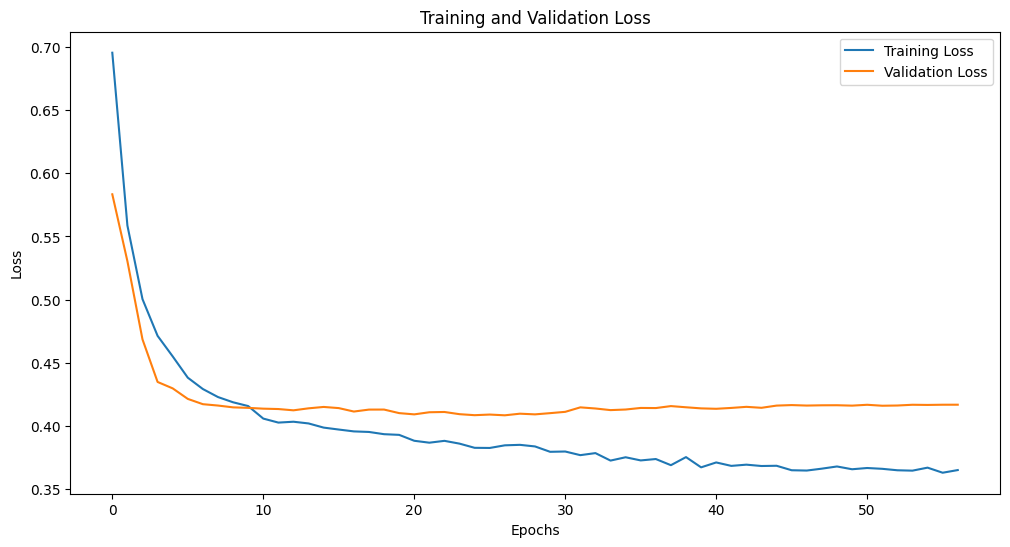

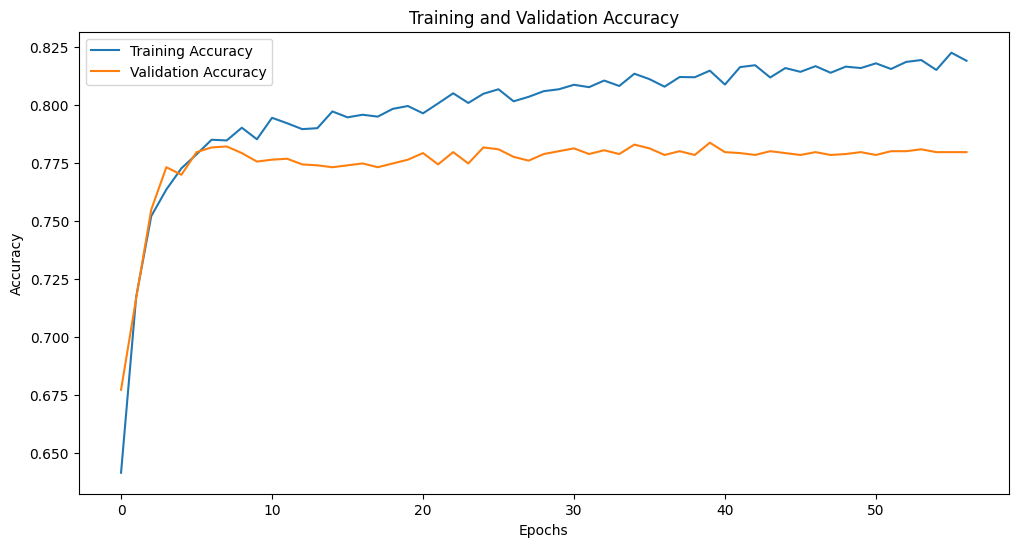

In [314]:
# Access the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Access the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [102]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [315]:
# Predict on the test set
predictions = model.predict(x_test)
predicted_classes = (predictions > 0.5).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print(f'Confusion Matrix: \n{conf_matrix}')

# Print the classification report
class_report = classification_report(y_test, predicted_classes)
print(f'Classification Report: \n{class_report}')

68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.8009216589861751
Confusion Matrix: 
[[ 725  185]
 [ 247 1013]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.75      0.80      0.77       910
        True       0.85      0.80      0.82      1260

    accuracy                           0.80      2170
   macro avg       0.80      0.80      0.80      2170
weighted avg       0.80      0.80      0.80      2170



This section bellow is to test the model on the training set, my best model has been saved as a file above. Feel free to load it here or just use the model that is gerated above. 

In [318]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('kickstarter_model.h5')

In [ ]:
# Import the test data and preprocess it
data = pd.read_excel('Kickstarter-Grading.xlsx')

# Remove the rows that are not of interest
data = data[data['state'] != 'live']
data = data[data['state'] != 'canceled']

# Create the new features
data['goal_usd'] = data['goal'] * data['static_usd_rate']
data['pledge_period'] = (data['deadline'] - data['launched_at']).dt.days
data['avg_pledge_daily'] = data['goal_usd'] / data['pledge_period']
countries = data['country'].value_counts()
countries = countries[countries > 100].index
data['other_country'] = np.where(data['country'].isin(countries), data['country'], 'Other')


# Log transform the goal_usd and avg_pledge_daily variables
data['goal_usd_log'] = np.log(data['goal_usd'])
data['avg_pledge_daily_log'] = np.log(data['avg_pledge_daily'])

# Treat the deadline month and launched_at month as categorical variables
data['deadline_month'] = data['deadline'].dt.month

# Treat the deadline year as a categorical variable
data['deadline_year'] = data['deadline'].dt.year

#Create dummies for the categorical variables
data = pd.get_dummies(data, columns = ['state', 'category', 'other_country', 'show_feature_image', 'video','deadline_weekday', 'launched_at_weekday', 'deadline_month', 'launched_at_month', 'deadline_year'], drop_first = False)
#Select the predictors and the target variable
numerical_predictors = ['goal_usd_log', 'avg_pledge_daily_log','pledge_period', 'static_usd_rate',  'name_len_clean', 'blurb_len_clean',]
categorical_predictors = [col for col in data.columns if 'category_' in col or 'other_country_' in col or 'show_feature_image_True' in col or 'video_True' in col or 'deadline_weekday_Thursday' in col or 'launched_at_weekday_Tuesday' in col or 'deadline_month_' in col or 'deadline_year_' in col ]  
predictors = numerical_predictors + categorical_predictors

test_data_x = data[predictors]
test_data_y = data['state_successful']

# standardize the continuous predictors
test_data_x[numerical_predictors] = scaler.transform(test_data_x[numerical_predictors])

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_27348\164534064.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_x[numerical_predictors] = scaler.transform(test_data_x[numerical_predictors])


In [322]:
# Predict on the test set
predictions = model.predict(test_data_x)
predicted_classes = (predictions > 0.5).astype(int)

# Calculate the accuracy
accuracy = accuracy_score(test_data_y, predicted_classes)
print(f'Accuracy: {accuracy}')

# Print the confusion matrix
conf_matrix = confusion_matrix(test_data_y, predicted_classes)
print(f'Confusion Matrix: \n{conf_matrix}')

# Print the classification report
class_report = classification_report(test_data_y, predicted_classes)
print(f'Classification Report: \n{class_report}')

452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.8140081587499136
Confusion Matrix: 
[[4899 1213]
 [1477 6874]]
Classification Report: 
              precision    recall  f1-score   support

       False       0.77      0.80      0.78      6112
        True       0.85      0.82      0.84      8351

    accuracy                           0.81     14463
   macro avg       0.81      0.81      0.81     14463
weighted avg       0.82      0.81      0.81     14463



# Task 2: Clustering

In [11]:
# Import the test data and preprocess it
data = pd.read_excel('Kickstarter.xlsx')

# Remove the rows that are not of interest
data = data[data['state'] != 'live']
data = data[data['state'] != 'canceled']

# Create the new features
data['goal_usd'] = data['goal'] * data['static_usd_rate']
data['pledge_period'] = (data['deadline'] - data['launched_at']).dt.days
data['avg_pledge_daily'] = data['goal_usd'] / data['pledge_period']
countries = data['country'].value_counts()
countries = countries[countries > 100].index
data['other_country'] = np.where(data['country'].isin(countries), data['country'], 'Other')


# Log transform the goal_usd and avg_pledge_daily variables
data['goal_usd_log'] = np.log(data['goal_usd'])
data['avg_pledge_daily_log'] = np.log(data['avg_pledge_daily'])
data['backers_count_log'] = np.log(data['backers_count'] + 1)
data['usd_pledged_log'] = np.log(data['usd_pledged'] + 1) 

# Treat the deadline month and launched_at month as categorical variables
data['deadline_month'] = data['deadline'].dt.month

# Treat the deadline year as a categorical variable
data['deadline_year'] = data['deadline'].dt.year

#Create dummies for the categorical variables
#data = pd.get_dummies(data, columns = ['state', 'main_category', 'other_country', 'show_feature_image', 'video', 'deadline_month', 'deadline_year', 'spotlight', 'staff_pick'], drop_first = True)

#Select the variables to analyze for clustering
numerical_vars = ['goal_usd_log','backers_count_log' ,'usd_pledged_log', 'static_usd_rate', "pledge_period"]
#categorical_vars = [col for col in data.columns if 'main_category_' in col or 'other_country_' in col or 'show_feature_image_True' in col or 'video_True' in col or  'deadline_month_' in col or 'deadline_year_' in col or 'state_' in col or 'spotlight_True' in col or 'staff_pick_True' in col]  
categorical_vars = ['state', 'main_category', 'other_country', 'show_feature_image', 'video', 'deadline_month', 'deadline_year', 'spotlight', 'staff_pick']
data = data[numerical_vars + categorical_vars]

# standardize the continuous variables
scaler = StandardScaler()
data[numerical_vars] = scaler.fit_transform(data[numerical_vars])


In [12]:
data.shape
for c in data.columns:
    print(c)
print(len(data.columns))

goal_usd_log
backers_count_log
usd_pledged_log
static_usd_rate
pledge_period
state
main_category
other_country
show_feature_image
video
deadline_month
deadline_year
spotlight
staff_pick
14


In [13]:
import gower

In [14]:
# Calculate the Gower distance since we are using both numerical and categorical variables
gower_dist = gower.gower_matrix(data)
display(gower_dist)

array([[0.        , 0.11956874, 0.12342961, ..., 0.18348983, 0.11728171,
        0.28104246],
       [0.11956874, 0.        , 0.11588878, ..., 0.20521945, 0.19065322,
        0.37420064],
       [0.12342961, 0.11588878, 0.        , ..., 0.09126957, 0.14813192,
        0.33167934],
       ...,
       [0.18348983, 0.20521945, 0.09126957, ..., 0.        , 0.12495583,
        0.26073506],
       [0.11728171, 0.19065322, 0.14813192, ..., 0.12495583, 0.        ,
        0.20493779],
       [0.28104246, 0.37420064, 0.33167934, ..., 0.26073506, 0.20493779,
        0.        ]], dtype=float32)

In [25]:
np.fill_diagonal(gower_dist, 0)

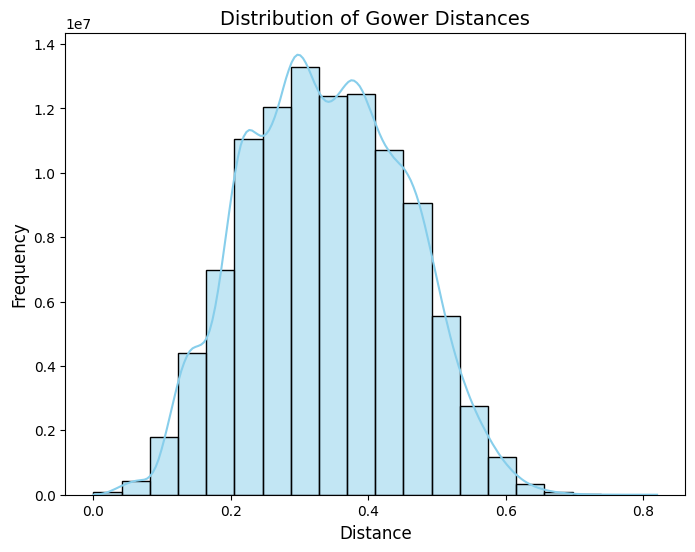

In [15]:
distances = gower_dist[np.triu_indices_from(gower_dist, k=1)]  # upper triangular matrix (excluding diagonal)

# Plot the distribution of the distances
plt.figure(figsize=(8, 6))
sns.histplot(distances, kde=True, bins=20, color='skyblue')
plt.title("Distribution of Gower Distances", fontsize=14)
plt.xlabel("Distance", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

In [ ]:
# Define the parameter grid for DBSCAN
param_grid = {
    'eps': np.linspace(0.001, 0.2, 20),  
    'min_samples': range(2, 10) 
}

# Generate all possible combinations of parameters
param_combinations = list(ParameterGrid(param_grid))
print(f'Total number of parameter combinations: {len(param_combinations)}')

Total number of parameter combinations: 140


In [49]:
# Initialize variables to keep track of the best model
best_score = -1  
best_params = None
best_labels = None

# Loop through each combination of parameters
for params in param_combinations:
    # Create the DBSCAN model
    db = DBSCAN(eps=params['eps'], min_samples=params['min_samples'], metric='precomputed')
    db.fit(gower_dist)
    labels = db.labels_
    
    # Check for the number of clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        print(f"Skipping: Only {n_clusters} clusters found for eps={params['eps']}, min_samples={params['min_samples']}")
        continue

    # Calculate silhouette score if at least two clusters exist
    score = silhouette_score(gower_dist, labels, metric='precomputed')
    if score > best_score:
        best_score = score
        best_params = params

# Print the best parameters and silhouette score
print(f"Best Parameters: {best_params}")
print(f"Best Silhouette Score: {best_score}")



Skipping: Only 0 clusters found for eps=0.001, min_samples=3
Skipping: Only 0 clusters found for eps=0.001, min_samples=4
Skipping: Only 0 clusters found for eps=0.001, min_samples=5
Skipping: Only 0 clusters found for eps=0.001, min_samples=6
Skipping: Only 0 clusters found for eps=0.001, min_samples=7
Skipping: Only 0 clusters found for eps=0.001, min_samples=8
Skipping: Only 0 clusters found for eps=0.001, min_samples=9
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=3
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=4
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=5
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=6
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=7
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=8
Skipping: Only 1 clusters found for eps=0.14763157894736842, min_samples=9
Skipping: Only 1 clusters found for eps=0.158105

In [ ]:
#Best Parameters: {'eps': np.float64(0.1371578947368421), 'min_samples': 7}
#Best Silhouette Score: 0.37365853786468506
db_best = DBSCAN(eps= best_params["eps"], min_samples=best_params["min_samples"], metric='precomputed')
db_best.fit(gower_dist)
labels = db_best.labels_

In [ ]:
print(np.unique(labels))

[-1  0  1]


In [42]:
data['cluster'] = labels
data['cluster'].value_counts()

cluster
 0    8336
 1    6103
-1      24
Name: count, dtype: int64

In [52]:
# Exclude noise points (-1) for clustering statistics
valid_data = data[data['cluster'] != -1]

# Numerical Variables: Descriptive Statistics by Cluster
numerical_stats = valid_data.groupby('cluster')[numerical_vars].agg(['mean', 'median', 'std', 'min', 'max'])

# Categorical Variables: Frequency Distribution by Cluster
categorical_stats = {}
for cat_var in categorical_vars:
    categorical_stats[cat_var] = valid_data.groupby('cluster')[cat_var].value_counts(normalize=True).unstack(fill_value=0)


In [54]:
# Display Results 
pd.set_option('display.max_columns', None)

print("Numerical Variables - Descriptive Statistics by Cluster:")
numerical_stats


Numerical Variables - Descriptive Statistics by Cluster:


goal_usd_log                                          \
                mean    median       std       min       max   
cluster                                                        
0          -0.241719 -0.149090  0.918575 -4.952457  2.956206   
1           0.328836  0.352972  1.012485 -4.795137  5.880574   

        backers_count_log                                          \
                     mean    median       std       min       max   
cluster                                                             
0                0.620543  0.594077  0.710127 -1.478371  4.111869   
1               -0.851410 -0.946379  0.650524 -1.880808  2.304029   

        usd_pledged_log                                         \
                   mean   median       std       min       max   
cluster                                                          
0              0.597286  0.61268  0.522025 -2.069239  3.100463   
1             -0.818945 -0.73048  0.914243 -2.305251  1.782611   

        static_usd_rate                                         pledge_period  \
                   mean    median       std       min       max          mean   
cluster                                                                         
0              0.016637  0.108758  0.976813 -3.505420  1.686445     -0.198697   
1             -0.014527  0.108758  1.018454 -3.505483  1.660046      0.271105   

                                                 
           median       std       min       max  
cluster                                          
0       -0.282247  0.872130 -2.517977  6.656225  
1       -0.282247  1.095093 -2.517977  2.493142

In [46]:
print("\nCategorical Variables - Frequency Distribution by Cluster:")
for var, stats in categorical_stats.items():
    print(f"\n{var}:")
    print(stats)


Categorical Variables - Frequency Distribution by Cluster:

state:
state    failed  successful
cluster                    
0           0.0         1.0
1           1.0         0.0

main_category:
main_category       Art    Comics    Crafts     Dance    Design   Fashion  \
cluster                                                                     
0              0.100570  0.015730  0.042730  0.011518  0.026505  0.109859   
1              0.107571  0.001807  0.058302  0.001478  0.044506  0.062572   

main_category  Film & Video      Food     Games  Journalism     Music  \
cluster                                                                 
0                  0.151845  0.053505  0.064652    0.015977  0.135621   
1                  0.133027  0.168172  0.047463    0.044342  0.083758   

main_category  Photography  Publishing  Technology   Theater  
cluster                                                       
0                 0.051771    0.155066    0.052762  0.011890  
1            

In [58]:
# Get the data for the excluded noise points
noise_data = data[data['cluster'] == -1]

# Divide the noise data into successful and failed projects
noise_successful = noise_data[noise_data['state'] == 'successful']
noise_failed = noise_data[noise_data['state'] == 'failed']

In [61]:
# get the descriptive statistics for the noise data
noise_stats = noise_successful[numerical_vars].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the results
print("Noise Data successful projects- Descriptive Statistics:")
noise_stats


Noise Data successful projects- Descriptive Statistics:


,goal_usd_log,backers_count_log,usd_pledged_log,static_usd_rate,pledge_period
mean,0.011741,1.212720,0.919398,-2.006692,0.195737
median,0.096448,1.523579,0.915132,-3.062398,-0.282247
std,1.097226,1.008904,0.700070,1.819202,1.215897
min,-1.865611,-0.840524,-0.172753,-3.503833,-1.669941
max,2.221538,2.539153,2.094604,1.269689,2.030577


In [62]:
# categorical distribution of the noise data
noise_categorical_stats = {}
for cat_var in categorical_vars:
    noise_categorical_stats[cat_var] = noise_successful[cat_var].value_counts(normalize=True)

# Display the results
print("\nNoise Data successful projects- Categorical Variables:")
for var, stats in noise_categorical_stats.items():
    print(f"\n{var}:")
    print(stats)


Noise Data successful projects- Categorical Variables:

state:
state
successful    1.0
Name: proportion, dtype: float64

main_category:
main_category
Comics          0.230769
Design          0.153846
Publishing      0.153846
Art             0.153846
Journalism      0.076923
Food            0.076923
Technology      0.076923
Film & Video    0.076923
Name: proportion, dtype: float64

other_country:
other_country
JP       0.266667
Other    0.200000
SE       0.200000
MX       0.133333
CA       0.066667
GB       0.066667
HK       0.066667
Name: proportion, dtype: float64

show_feature_image:
show_feature_image
True     0.6
False    0.4
Name: proportion, dtype: float64

video:
video
False    0.8
True     0.2
Name: proportion, dtype: float64

deadline_month:
deadline_month
7     0.200000
5     0.200000
4     0.133333
2     0.133333
1     0.133333
12    0.133333
6     0.066667
Name: proportion, dtype: float64

deadline_year:
deadline_year
2022    0.200000
2021    0.200000
2020    0.200000
2017

In [60]:
# get the descriptive statistics for the noise data
noise_stats = noise_failed[numerical_vars].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the results
print("Noise Data - Descriptive Statistics:")
noise_stats


Noise Data - Descriptive Statistics:


,goal_usd_log,backers_count_log,usd_pledged_log,static_usd_rate,pledge_period
mean,0.879220,0.568469,0.583679,-2.213861,-0.128058
median,0.884384,0.329316,0.466535,-3.064771,-0.205153
std,0.704098,0.733786,0.467507,1.813523,0.904009
min,0.018641,-0.348588,0.018545,-3.503867,-2.055412
max,2.145101,1.729671,1.431829,1.594159,1.182542


In [63]:
# categorical distribution of the noise data
noise_categorical_stats = {}
for cat_var in categorical_vars:
    noise_categorical_stats[cat_var] = noise_failed[cat_var].value_counts(normalize=True)

# Display the results
print("\nNoise Data - Categorical Variables:")
for var, stats in noise_categorical_stats.items():
    print(f"\n{var}:")
    print(stats)


Noise Data - Categorical Variables:

state:
state
failed    1.0
Name: proportion, dtype: float64

main_category:
main_category
Fashion         0.222222
Film & Video    0.222222
Publishing      0.222222
Design          0.111111
Music           0.111111
Technology      0.111111
Name: proportion, dtype: float64

other_country:
other_country
JP    0.333333
HK    0.222222
AU    0.111111
CA    0.111111
MX    0.111111
SE    0.111111
Name: proportion, dtype: float64

show_feature_image:
show_feature_image
False    1.0
Name: proportion, dtype: float64

video:
video
True     0.555556
False    0.444444
Name: proportion, dtype: float64

deadline_month:
deadline_month
12    0.444444
4     0.333333
1     0.222222
Name: proportion, dtype: float64

deadline_year:
deadline_year
2017    0.444444
2018    0.111111
2020    0.111111
2019    0.111111
2022    0.111111
2023    0.111111
Name: proportion, dtype: float64

spotlight:
spotlight
False    1.0
Name: proportion, dtype: float64

staff_pick:
staff_pick
